## EEG microstate analysis

This script provides an illustration of a microstate analysis using the pycrostates & neurokit2 packages.

Author: Ruxandra I. Tivadar, code adapted from V. Ferat (https://pycrostates.readthedocs.io) 

Microstate analysis in the pycrostates package uses the "Kmeans" or clusterization algorithm, that groups objects into k groups based on their characteristics. The grouping is done by minimizing the sum of the distances between each object and the group or cluster centroid. 

We show two methods: 
1) microstates for the full group: the aim is to compare temporal characteristics (i.e. are the microstates present for different periods of time in the two groups)?
2) microstates for each condition: is there any microstate map that is specific to one or the other condition?

In [ ]:
# if some packages do not load on the google site, use command below
#!pip install neurokit2

In [ ]:
---
tags: [hide-output]
---
!pip install neurokit2 
!pip install mne
!pip install pycrostates 

In [2]:
# For elimiating warnings

import warnings
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
# import packages that contain all the functions you need to use

import numpy as np
import mne
import os
import matplotlib.pyplot as plt
from mne.io import read_raw_fif, concatenate_raws, read_raw_eeglab
import copy
from scipy import signal
import mne.viz
import natsort
import seaborn as sns

from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.datasets import lemon
from pycrostates.io import ChData

import neurokit2 as nk

In [4]:
# define dataset characteristics
condition = ['EO','EC']
subject_ids = ["010020", "010021", "010022", "010023", "010024"]

### Option nr 1

We compute microstates for the full group, combining files from the two conditions

In [5]:
individual_cluster_centers = list()
for subject_id in subject_ids:
    for condition_id in condition:
    # load Data
        raw_fname = lemon.data_path(subject_id=subject_id, condition=condition_id)
        print('loading data for subject:', str(subject_id), '& condition:', str(condition_id))
        raw = read_raw_eeglab(raw_fname, preload=True)
        raw = lemon.standardize(raw)
        raw.pick("eeg")
        raw.crop(0, 30)  # crop the dataset to speed up computation
        raw.set_eeg_reference("average")
        # extract GFP peaks
        gfp_peaks = extract_gfp_peaks(raw)
        # subject level clustering
        ModK = ModKMeans(n_clusters=5, random_state=42)
        ModK.fit(gfp_peaks, n_jobs=2)
        # check your raw data
        ModK.plot()
        individual_cluster_centers.append(ModK.cluster_centers_)


loading data for subject: 010020 & condition: EO
Reading /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010020_EO.fdt
Reading 0 ... 104402  =      0.000 ...   417.608 secs...
Creating RawArray with float64 data, n_channels=61, n_times=104403
    Range : 0 ... 104402 =      0.000 ...   417.608 secs
Ready.
Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
loading data for subject: 010020 & con

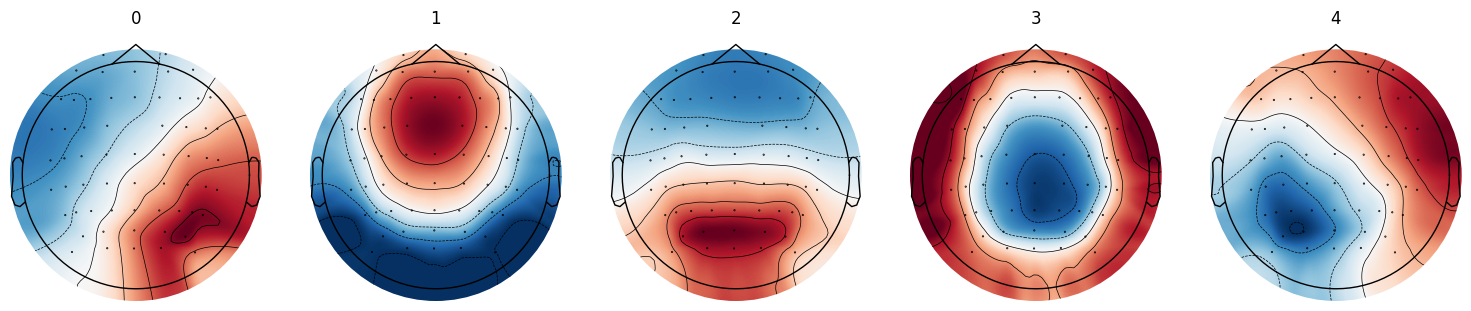

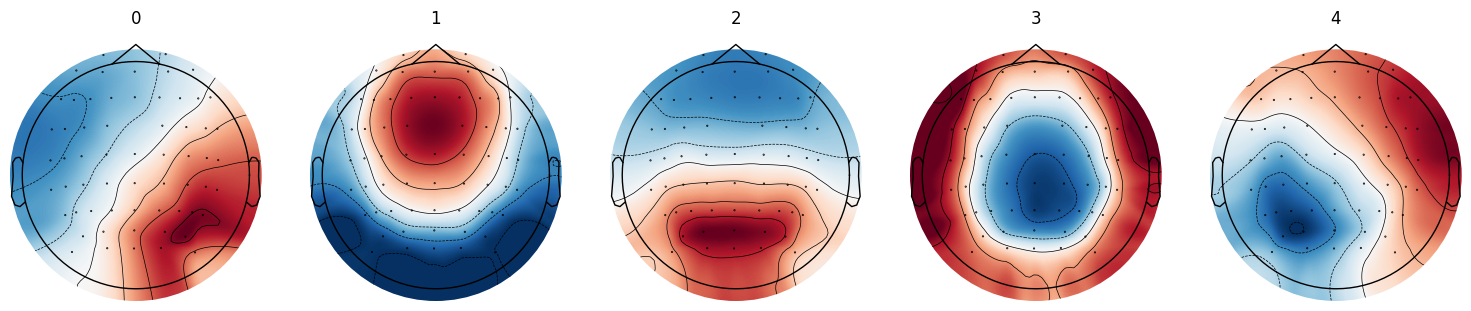

In [6]:
# Then, the individual topographies are concatenated and used in the group level analysis to fit a second clustering algorithm.

group_cluster_centers = np.vstack(individual_cluster_centers).T
group_cluster_centers = ChData(group_cluster_centers, ModK.info)

# group level clustering
ModK = ModKMeans(n_clusters=5, random_state=42)
ModK.fit(group_cluster_centers, n_jobs=2)
ModK.plot()

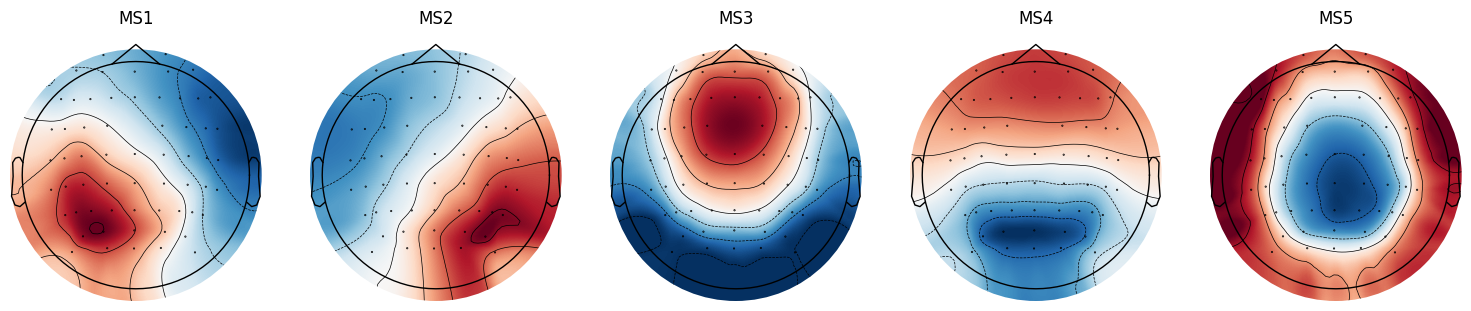

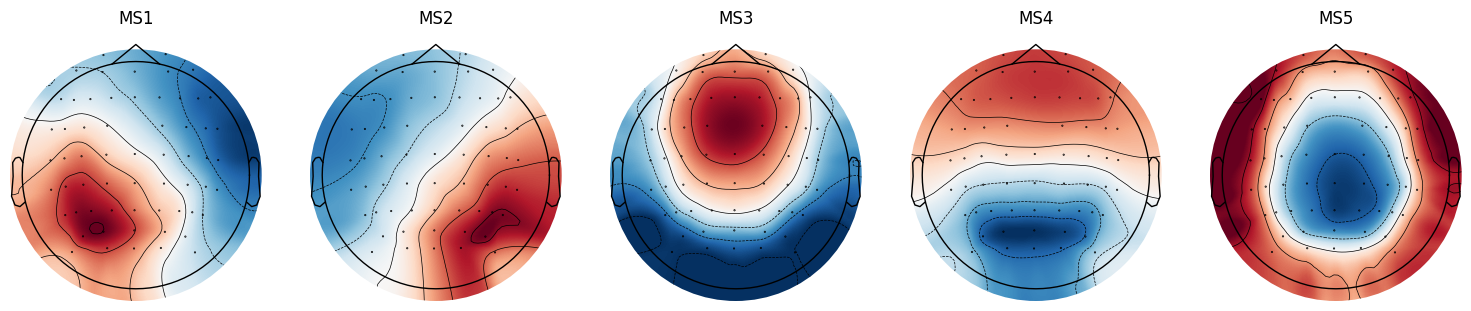

In [7]:
# The map polarities can be inverted using the pycrostates.cluster.ModKMeans.invert_polarity(). method. 
# Note that it only affects visualization, it has not effect during backfitting as polarities are ignored.

ModK.invert_polarity([False, False, True, False, True])
ModK.reorder_clusters(order=[4, 0, 1, 2, 3])
ModK.rename_clusters(new_names=["MS1", "MS2", "MS3", "MS4", "MS5"])
ModK.plot()

In [ ]:
% matplotlib tk
n_optimal, scores = nk.microstates_findnumber(ModK._fitted_data, n_max = 8, sampling_rate=sampling_rate, show=True)
print("Optimal number of microstates: ", n_optimal)

As a comparison, here are some results found by other teams when doing microstate analysis (figure taken from {cite}`MICHEL2018577`).

In [ ]:
from IPython.display import Image
Image("microstate_results.jpg")

### backfitting

In [8]:
ms_data = list()
segmentation_group = list()

for subject_id in subject_ids:
    for condition_id in condition:
    # Load Data
        raw_fname = lemon.data_path(subject_id=subject_id, condition=condition_id)
        raw = read_raw_eeglab(raw_fname, preload=True)
        raw = lemon.standardize(raw)
        raw.pick("eeg")
        raw.crop(0, 30)  # for sake of time
        raw.set_eeg_reference("average")
        segmentation = ModK.predict(raw, factor=10, half_window_size=8)
        d = segmentation.compute_parameters()
        d["condition_id"] = condition_id
        d["subject_id"] = subject_id
        ms_data.append(d)

In [ ]:
# save data to a .CSV
import pandas as pd
fname_s = path + 'MS_'+session_prefix.split('_')[1]+'_segmentation_params.csv'
df = pd.DataFrame.from_dict(ms_data) 
df.to_csv(fname_s, index=False, header=True)

In [9]:
data_EC = [d for d in ms_data if d['condition_id'] == 'EC']
data_EO = [d for d in ms_data if d['condition_id'] == 'EO']

GEV_EC = [
    [d['MS1_gev'], d['MS2_gev'], d['MS3_gev'], d['MS4_gev'], d['MS5_gev']]
    for d in data_EC
]
GEV_EO = [
    [d['MS1_gev'], d['MS2_gev'], d['MS3_gev'], d['MS4_gev'], d['MS5_gev']]
    for d in data_EO
]


In [10]:
GEV_EC == GEV_EO

False

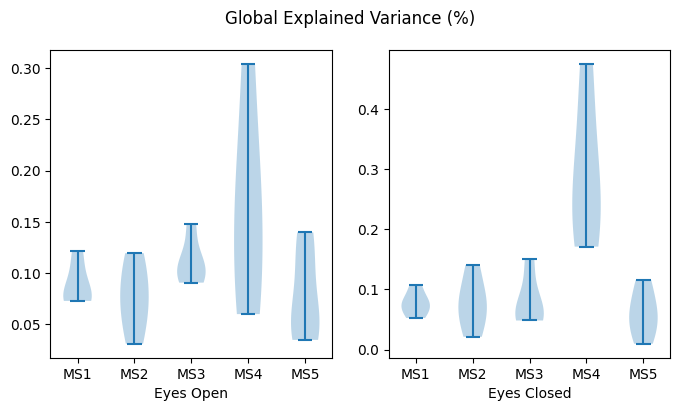

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
names = ModK.cluster_names
ax1.violinplot(np.array(GEV_EO))
ax1.set_xticks(
    ticks=range(1, len(names) + 1),
    labels=names,
)
ax1.set_xlabel("Eyes Open")

ax2.violinplot(np.array(GEV_EC))
ax2.set_xticks(
    ticks=range(1, len(names) + 1),
    labels=names,
)
ax2.set_xlabel("Eyes Closed")
fig.suptitle("Global Explained Variance (%)")
plt.show()

In [12]:
Total_gev_EO = np.array(GEV_EO)
Total_gev_EC = np.array(GEV_EC)

sum_EO = np.sum(np.mean(Total_gev_EO, axis=1))
sum_EC = np.sum(np.mean(Total_gev_EC, axis=1))

print('Total explained variance is - EO:', sum_EO, '& EC:', sum_EC)

Total explained variance is - EO: 0.5147167463252209 & EC: 0.5874373582710964


In [13]:
mean_dur_EC = [
    [d['MS1_meandurs'], d['MS2_meandurs'], d['MS3_meandurs'], d['MS4_meandurs'], d['MS5_meandurs']]
    for d in data_EC
]
mean_dur_EO = [
    [d['MS1_meandurs'], d['MS2_meandurs'], d['MS3_meandurs'], d['MS4_meandurs'], d['MS5_meandurs']]
    for d in data_EO
]


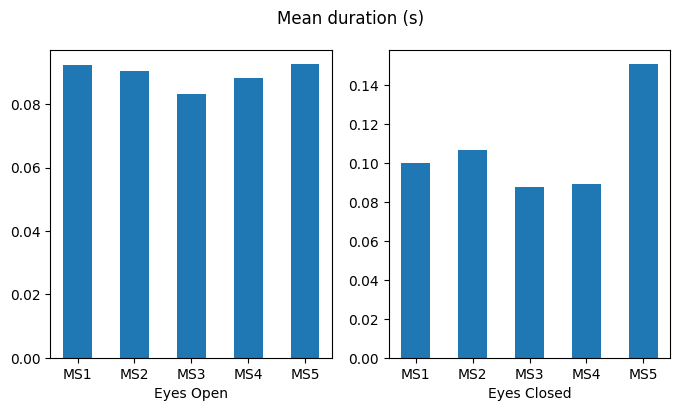

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

x1 = ModK.cluster_names
y1 = np.array(mean_dur_EO)
y2 = np.array(mean_dur_EC)

ax1.bar(x1, np.mean(y1, axis=1), align='center', width=0.5)
ax1.set_xlabel("Eyes Open")

ax2.bar(x1, np.mean(y2, axis=1), align='center', width=0.5)
ax2.set_xlabel("Eyes Closed")

fig.suptitle("Mean duration (s)")
plt.show()


### Option nr 2

We compute microstates for each of the conditions.

In [15]:
individual_cluster_centers_EO = []

condition = 'EO'
for subject_id in subject_ids:
    # load Data
    raw_fname = lemon.data_path(subject_id=subject_id, condition=condition)
    print('dataname:', raw_fname)
    print('loading data for subject:', str(subject_id), '& condition:', str(condition))
    raw = read_raw_eeglab(raw_fname, preload=True)
    raw = lemon.standardize(raw)
    raw.pick("eeg")
    raw.crop(0, 30)  # crop the dataset to speed up computation
    raw.set_eeg_reference("average")
    # extract GFP peaks
    gfp_peaks = extract_gfp_peaks(raw)
    # subject level clustering
    ModK = ModKMeans(n_clusters=5, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=2)
    individual_cluster_centers_EO.append(ModK.cluster_centers_)


dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010020_EO.set
loading data for subject: 010020 & condition: EO
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010021_EO.set
loading data for subject: 010021 & condition: EO
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010022_EO.set
loading data for subject: 010022 & condition: EO
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010023_EO.set
loading data for subject: 010023 & condition: EO
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010024_EO.set
loading data for subject: 010024 & condition: EO


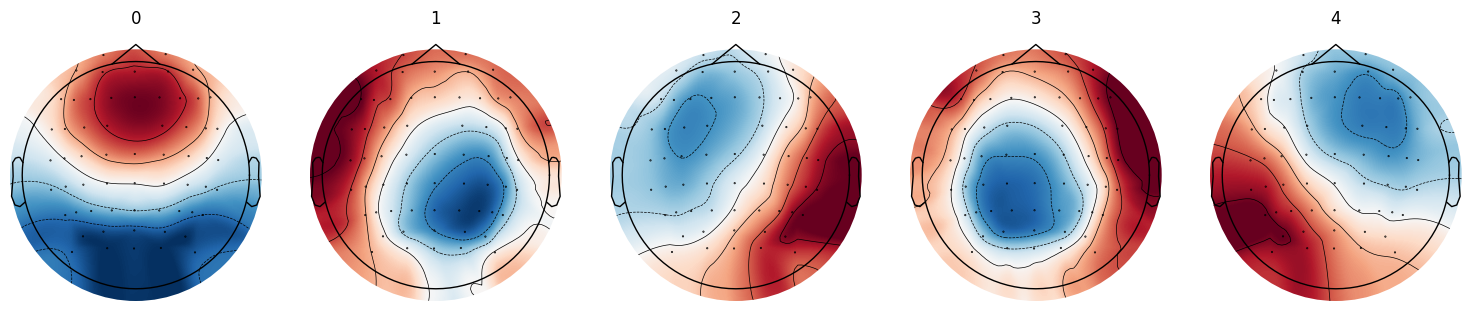

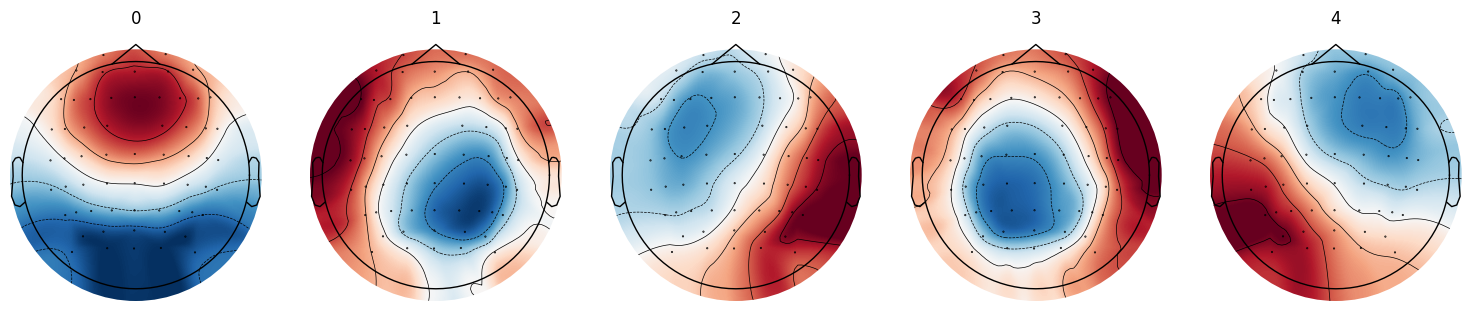

In [16]:
# we first combine all the files into a dataset 
group_cluster_centers_EO = np.vstack(individual_cluster_centers_EO).T
group_cluster_centers_EO = ChData(group_cluster_centers_EO, ModK.info) # stores data without time (only spatial component)

# and do group-level clustering
ModK_g_EO = ModKMeans(n_clusters=5, random_state=42)
ModK_g_EO.fit(group_cluster_centers_EO, n_jobs=2)
ModK_g_EO.plot()

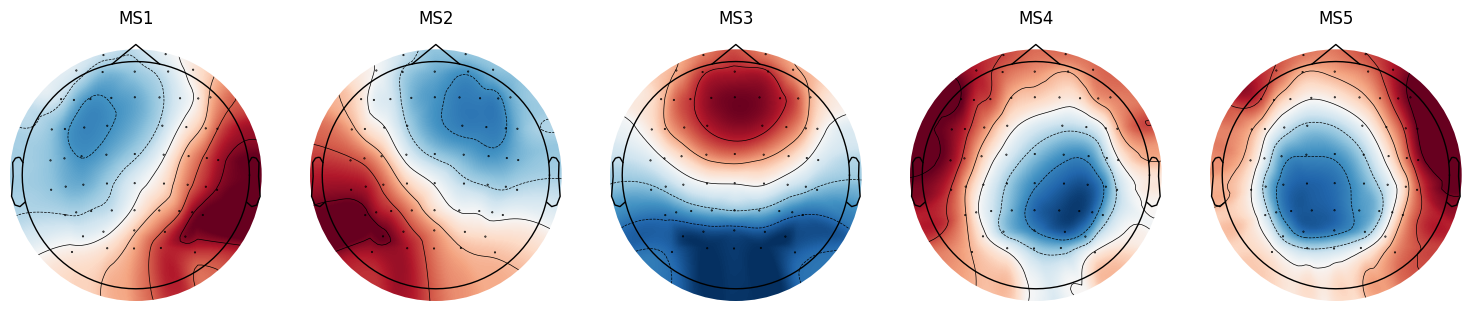

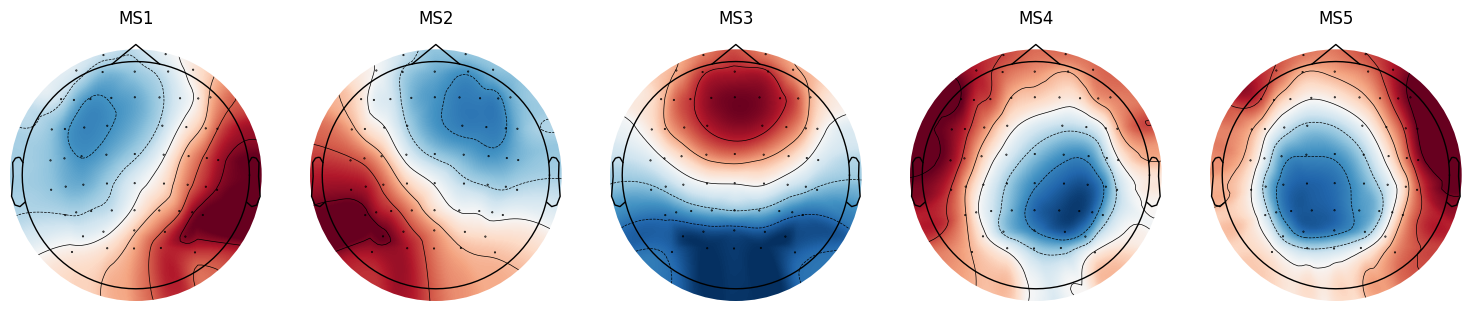

In [17]:
# The map polarities can be inverted using the pycrostates.cluster.ModKMeans.invert_polarity(). method. 
# Note that it only affects visualization, it has not effect during backfitting as polarities are ignored.

ModK_g_EO.reorder_clusters(order=[2, 4, 0, 1, 3])
ModK_g_EO.rename_clusters(new_names=["MS1", "MS2", "MS3", "MS4", "MS5"])
ModK_g_EO.plot()

In [18]:
individual_cluster_centers_EC = []

condition = 'EC'
for subject_id in subject_ids:
    # load Data
    raw_fname = lemon.data_path(subject_id=subject_id, condition=condition)
    print('dataname:', raw_fname)
    print('loading data for subject:', str(subject_id), '& condition:', str(condition))
    raw = read_raw_eeglab(raw_fname, preload=True)
    raw = lemon.standardize(raw)
    raw.pick("eeg") 
    raw.crop(0, 30)  
    raw.set_eeg_reference("average")
    gfp_peaks = extract_gfp_peaks(raw)
    ModK = ModKMeans(n_clusters=5, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=2)
    individual_cluster_centers_EC.append(ModK.cluster_centers_)

dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010020_EC.set
loading data for subject: 010020 & condition: EC
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010021_EC.set
loading data for subject: 010021 & condition: EC
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010022_EC.set
loading data for subject: 010022 & condition: EC
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010023_EC.set
loading data for subject: 010023 & condition: EC
dataname: /Users/tivadarr/pycrostates_data/PREPROCESSED_LEMON/sub-010024_EC.set
loading data for subject: 010024 & condition: EC


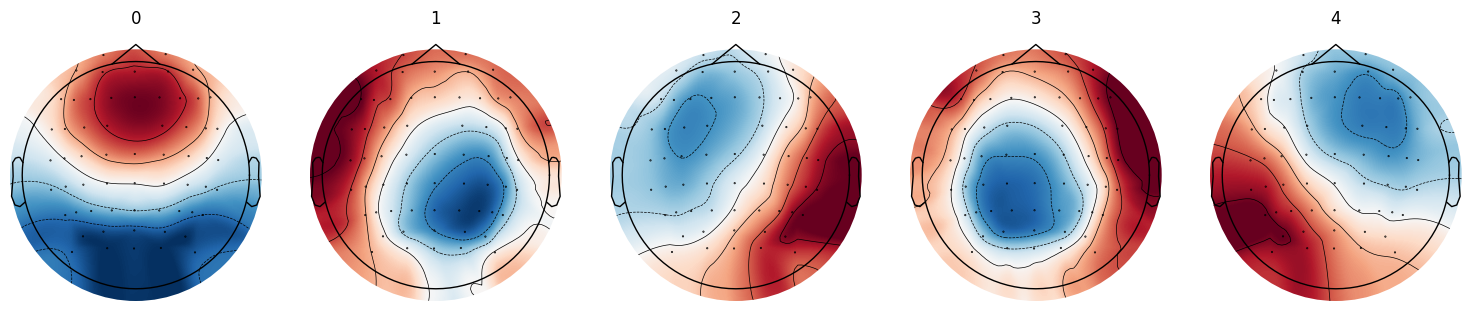

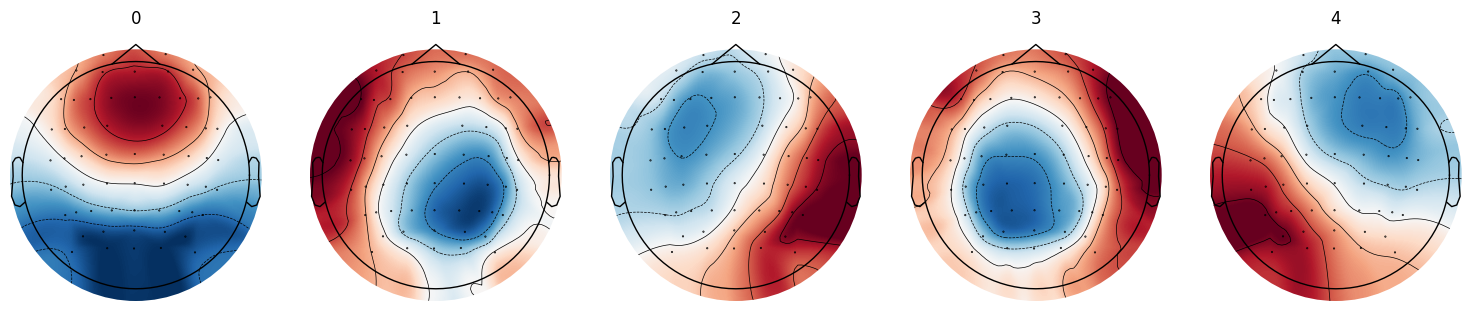

In [19]:
# we first combine all the files into a dataset 
group_cluster_centers_EC = np.vstack(individual_cluster_centers_EC).T
group_cluster_centers_EC = ChData(group_cluster_centers_EC, ModK.info) # stores data without time (only spatial component)

# and do group-level clustering
ModK_g_EC = ModKMeans(n_clusters=5, random_state=42)
ModK_g_EC.fit(group_cluster_centers_EO, n_jobs=2)
ModK_g_EC.plot()

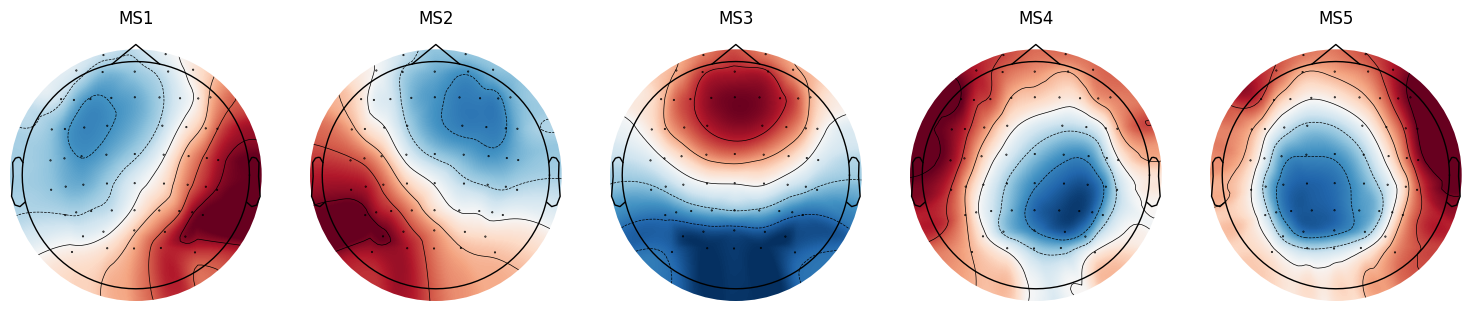

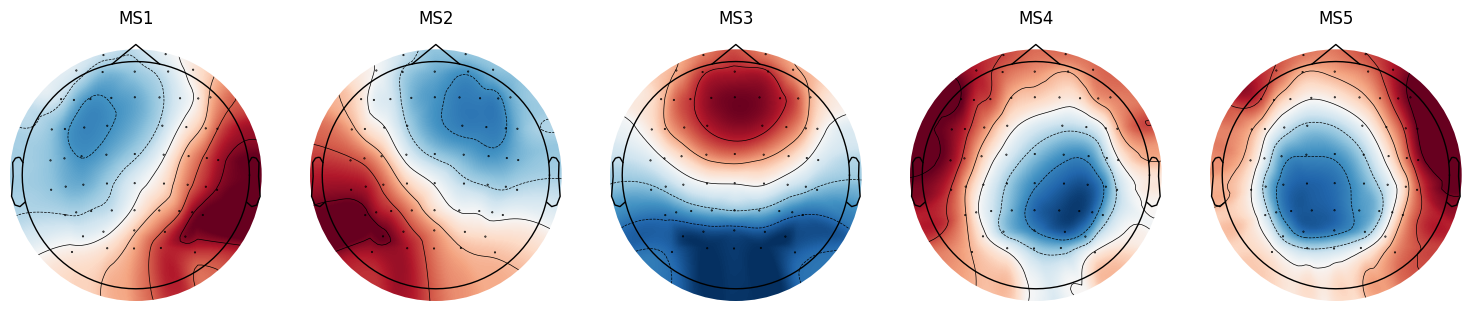

In [20]:
# The map polarities can be inverted using the pycrostates.cluster.ModKMeans.invert_polarity(). method. 
# Note that it only affects visualization, it has not effect during backfitting as polarities are ignored.

#ModK.invert_polarity([False, False, True, False, True])
ModK_g_EC.reorder_clusters(order=[2,4, 0, 1, 3])
ModK_g_EC.rename_clusters(new_names=["MS1", "MS2", "MS3", "MS4", "MS5"])
ModK_g_EC.plot()

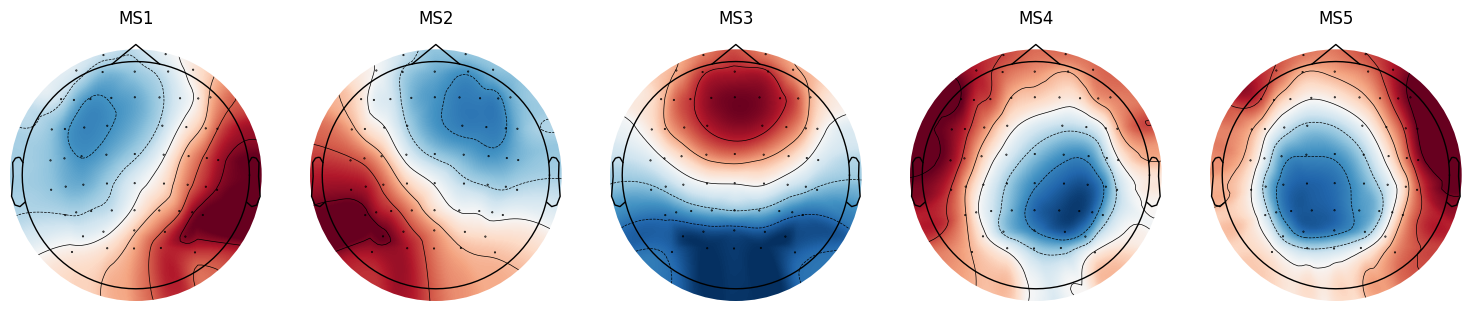

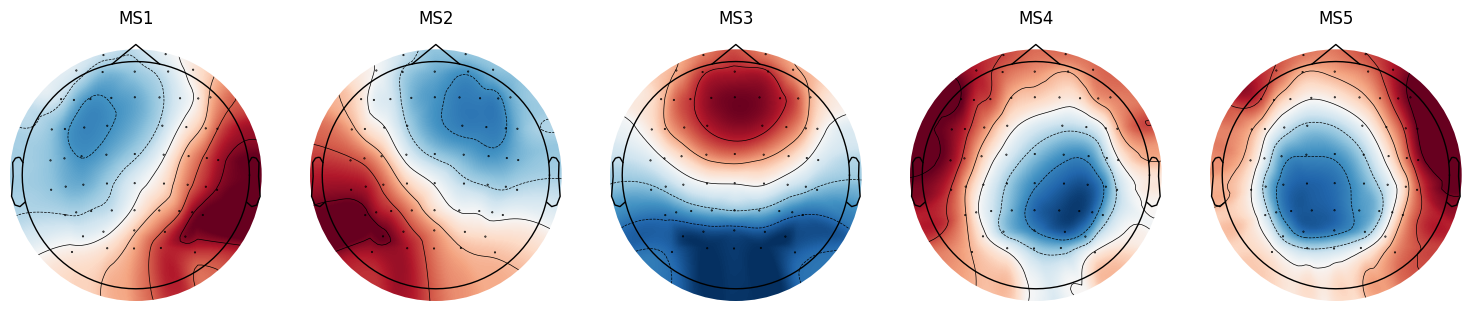

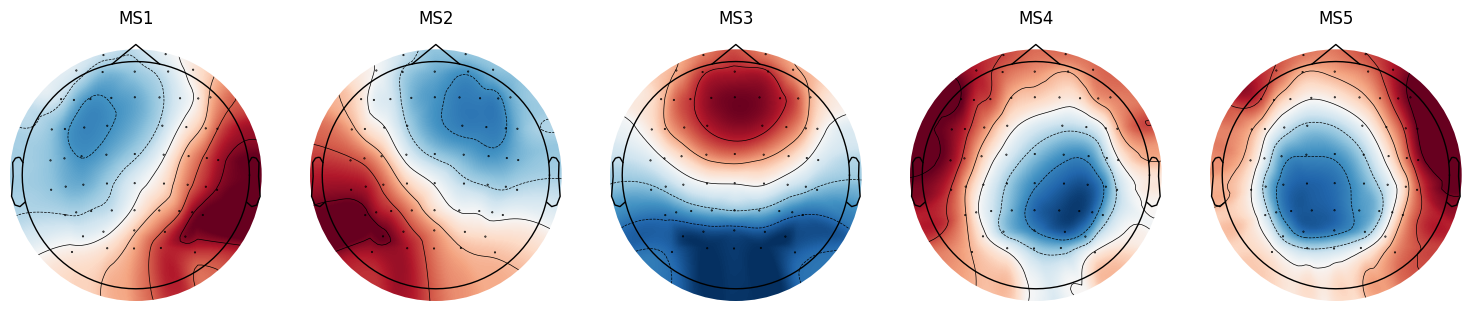

In [21]:
ModK_g_EC.plot()
ModK_g_EO.plot()

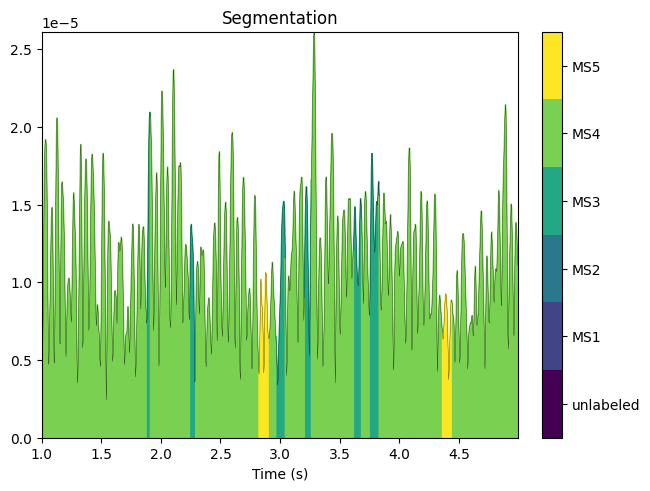

In [22]:
segmentation.plot(tmin=1, tmax=5)
plt.show()

In [ ]:
import csv

MS_no =['MS1', 'MS2','MS3','MS4','MS5']
group_pci = list()
group_curss = list()
for no in range(len(MS_no)):
    group_ec.append(ModK_g_EC.cluster_centers_[no])
    group_eo.append(ModK_g_EO.cluster_centers_[no])
d=dict(zip(MS_no,group_ec,group_eo))

fname = path + 'MS_topographies_segmentation_params.csv'

df = pd.DataFrame.from_dict(d) 
df.to_csv(fname, index=False, header=True)